<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Simple_method_Jan12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

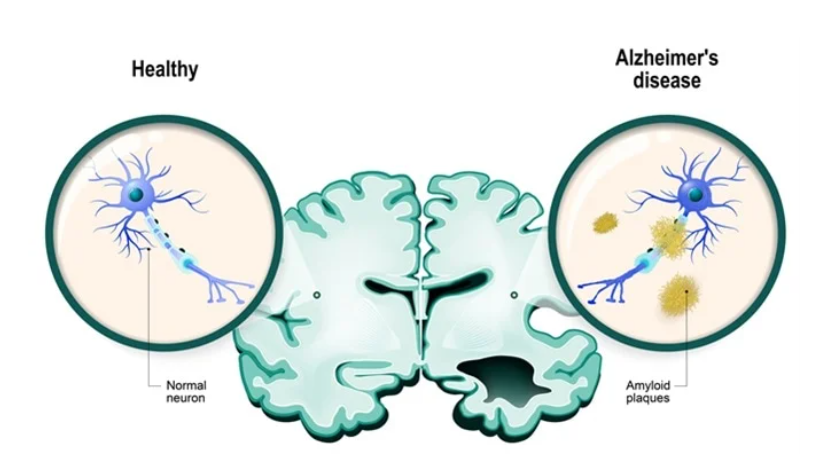

> Alzheimer's disease is the most common type of dementia. It is a progressive disease beginning with mild memory loss and possibly leading to loss of the ability to carry on a conversation and respond to the environment. Alzheimer's disease involves parts of the brain that control thought, memory, and language.



# Import Libraries

In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import seaborn as sns
import pathlib
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from IPython import get_ipython
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Download datasets directly from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("katalniraj/adni-extracted-axial")

print("Path to dataset files:", path)

100%|██████████| 102M/102M [00:06<00:00, 16.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/katalniraj/adni-extracted-axial/versions/1


> The kagglehub library is used to interact with Kaggle's datasets, models, and other resources. It provides functions to download datasets directly from Kaggle.

> The dataset_download function is used to download a dataset from Kaggle. The argument "katalniraj/adni-extracted-axial" specifies the dataset to download. This is the dataset's identifier on Kaggle, where katalniraj is the user who uploaded the dataset, and adni-extracted-axial is the name of the dataset.

> The function returns the path where the dataset is downloaded. This path is stored in the variable path.

> This line prints the path where the dataset files are stored. This is useful for verifying that the dataset has been downloaded correctly and to know where the files are located.



# Loading the Dataset for Training

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/root/.cache/kagglehub/datasets/katalniraj/adni-extracted-axial/versions/1/Axial",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/root/.cache/kagglehub/datasets/katalniraj/adni-extracted-axial/versions/1/Axial",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5154 files belonging to 3 classes.
Using 4124 files for training.
Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


> The image_dataset_from_directory function from TensorFlow's keras.preprocessing module is used to load images from a directory into a tf.data.Dataset object.



> Arguments:

"/root/.cache/kagglehub/datasets/katalniraj/adni-extracted-axial/versions/1": This is the path to the directory containing the dataset. It assumes that the dataset is organized in subdirectories, where each subdirectory represents a class.

validation_split=0.2: This specifies that 20% of the data should be reserved for validation.

subset="training": This indicates that the current dataset should contain the training portion of the data (80% in this case).

seed=1337: This sets a random seed for reproducibility when splitting the data into training and validation sets.

image_size=[180, 180]: This resizes all images to 180x180 pixels.

batch_size=16: This specifies that the dataset should be batched into groups of 16 images.

> The resulting train_ds is a tf.data.Dataset object that can be used for training a machine learning model.



## Summary
1. The code downloads a dataset from Kaggle using the kagglehub library.

2. It then loads the dataset into TensorFlow Dataset objects for both training and validation, with images resized to 180x180 pixels and batched into groups of 16.

3. The dataset is split into 80% training and 20% validation sets, with a fixed random seed for reproducibility.

## number and names of Classes

In [12]:
classnames = train_ds.class_names
len(classnames),train_ds.class_names

(3, ['AD', 'CI', 'CN'])

# Data Visualization

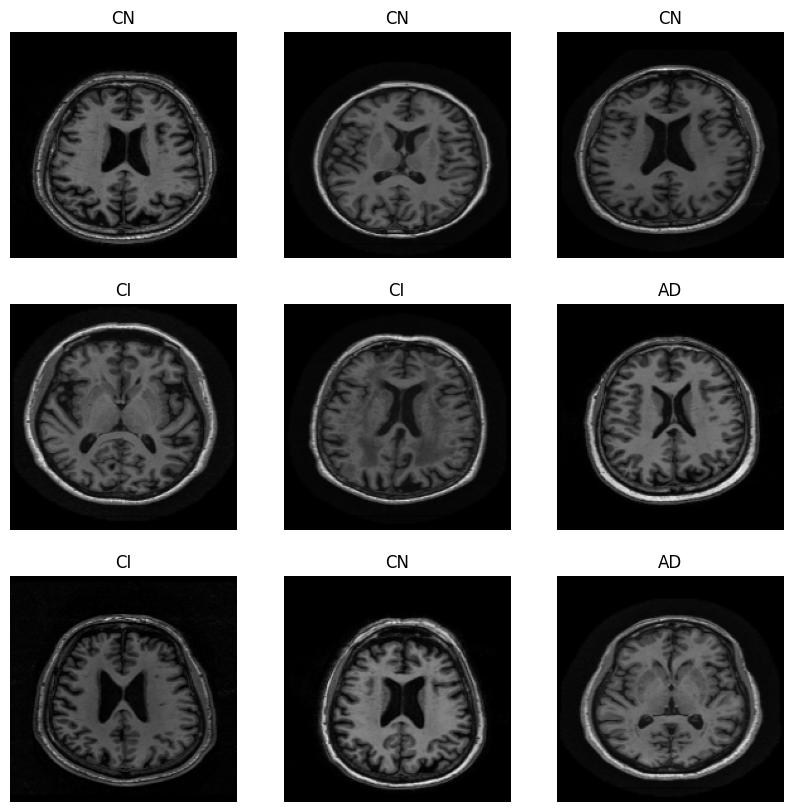

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

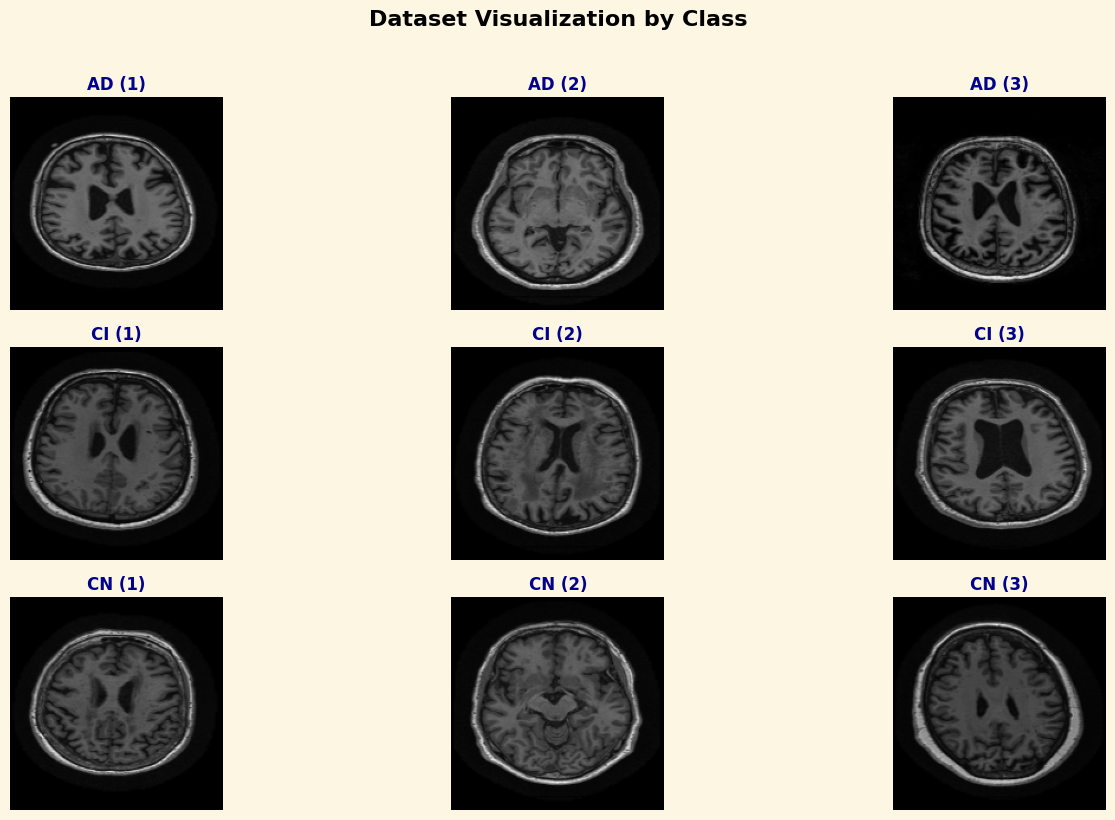

In [45]:
def visualize_images_by_class(dataset, class_names, images_per_class=3, figsize=(15, 8)):
    """
    Visualizes images from a TensorFlow dataset, grouped by class, with a beautiful template.

    Args:
        dataset (tf.data.Dataset): The dataset to visualize.
        class_names (list): List of class names corresponding to the labels.
        images_per_class (int): Number of images to display for each class.
        figsize (tuple): Size of the figure (width, height).
    """
    # Initialize a dictionary to store images for each class
    class_images = {class_name: [] for class_name in class_names}

    # Iterate through the dataset to collect images for each class
    for images, labels in dataset.take(-1):  # Use -1 to iterate through the entire dataset
        for image, label in zip(images, labels):
            class_name = class_names[label]
            if len(class_images[class_name]) < images_per_class:
                class_images[class_name].append(image.numpy().astype("uint8"))

            # Stop if we have enough images for all classes
            if all(len(images) >= images_per_class for images in class_images.values()):
                break
        else:
            continue
        break

    # Apply a beautiful style template
    plt.style.use('Solarize_Light2')  # Use a predefined style template

    # Plot the images in a grid
    num_classes = len(class_names)
    plt.figure(figsize=figsize)

    for i, class_name in enumerate(class_names):
        for j in range(images_per_class):
            ax = plt.subplot(num_classes, images_per_class, i * images_per_class + j + 1)
            plt.imshow(class_images[class_name][j])
            plt.title(f"{class_name} ({j+1})", fontsize=12, fontweight='bold', color='darkblue')
            plt.axis("off")

    # Add a super title for the entire figure
    plt.suptitle("Dataset Visualization by Class", fontsize=16, fontweight='bold', y=1.02)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Usage
visualize_images_by_class(train_ds, train_ds.class_names, images_per_class=3, figsize=(15, 8))

In [33]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

> This code defines a function visualize_images_by_class that visualizes images from a TensorFlow dataset, grouped by their class labels. It uses matplotlib to create a grid of images, with each row representing a class and each column representing an image from that class.


### **Function Definition**
```python
def visualize_images_by_class(dataset, class_names, images_per_class=3, figsize=(15, 8)):
```
- **Purpose**: The function visualizes images from a TensorFlow dataset, grouped by their class labels.
- **Arguments**:
  - `dataset`: A TensorFlow dataset containing images and their corresponding labels.
  - `class_names`: A list of class names corresponding to the labels.
  - `images_per_class`: The number of images to display for each class (default is 3).
  - `figsize`: The size of the figure (width, height) for the visualization (default is `(15, 8)`).

---

### **Step 1: Initialize a Dictionary to Store Images**
```python
class_images = {class_name: [] for class_name in class_names}
```
- A dictionary `class_images` is created to store images for each class. The keys are the class names, and the values are lists that will hold the images for each class.

---

### **Step 2: Iterate Through the Dataset**
```python
for images, labels in dataset.take(-1):
```
- The `dataset.take(-1)` ensures that the entire dataset is iterated through (if necessary) to collect enough images for each class.
- `images` and `labels` are the batches of images and their corresponding labels from the dataset.

---

### **Step 3: Collect Images for Each Class**
```python
for image, label in zip(images, labels):
    class_name = class_names[label]
    if len(class_images[class_name]) < images_per_class:
        class_images[class_name].append(image.numpy().astype("uint8"))
```
- For each image and label in the batch:
  - The class name is determined using `class_names[label]`.
  - If the number of images collected for that class is less than `images_per_class`, the image is added to the list for that class.
  - The image is converted to a NumPy array and cast to `uint8` (8-bit unsigned integer) for compatibility with `matplotlib`.

---

### **Step 4: Stop When Enough Images Are Collected**
```python
if all(len(images) >= images_per_class for images in class_images.values()):
    break
```
- The loop breaks early if enough images have been collected for all classes. This avoids unnecessary iteration through the dataset.

---

### **Step 5: Apply a Beautiful Style Template**
```python
plt.style.use('Solarize_Light2')
```
- The `Solarize_Light2` style template is applied to make the visualization more aesthetically pleasing. This is one of the predefined styles in `matplotlib`.

---

### **Step 6: Plot the Images in a Grid**
```python
num_classes = len(class_names)
plt.figure(figsize=figsize)

for i, class_name in enumerate(class_names):
    for j in range(images_per_class):
        ax = plt.subplot(num_classes, images_per_class, i * images_per_class + j + 1)
        plt.imshow(class_images[class_name][j])
        plt.title(f"{class_name} ({j+1})", fontsize=12, fontweight='bold', color='darkblue')
        plt.axis("off")
```
- A figure is created with the specified size (`figsize`).
- A grid of subplots is created, with `num_classes` rows and `images_per_class` columns.
- For each class and each image:
  - The image is displayed using `plt.imshow`.
  - The title of the subplot is set to the class name and the image number (e.g., `AD (1)`).
  - The axes are turned off (`plt.axis("off")`) to remove the borders around the images.

---

### **Step 7: Add a Super Title**
```python
plt.suptitle("Dataset Visualization by Class", fontsize=16, fontweight='bold', y=1.02)
```
- A super title is added to the entire figure to describe the visualization. The `y=1.02` parameter adjusts the vertical position of the title.

---

### **Step 8: Adjust Layout and Display**
```python
plt.tight_layout()
plt.show()
```
- `plt.tight_layout()` ensures that the subplots are neatly arranged without overlapping.
- `plt.show()` displays the figure.

---

### **Usage**
```python
visualize_images_by_class(train_ds, train_ds.class_names, images_per_class=3, figsize=(15, 8))
```
- The function is called with the following arguments:
  - `train_ds`: The TensorFlow dataset to visualize.
  - `train_ds.class_names`: The list of class names.
  - `images_per_class=3`: Display 3 images per class.
  - `figsize=(15, 8)`: Set the figure size to 15x8 inches.


### **Key Features**
1. **Flexibility**:
   - The function can handle any number of classes and images per class.
   - The figure size and style template can be customized.

2. **Efficiency**:
   - The loop breaks early once enough images are collected, saving computation time.

3. **Aesthetics**:
   - The use of a predefined style template (`Solarize_Light2`) and custom titles makes the visualization visually appealing.

